### Compute LDA with both gensim and sklearn for the toy_corpus & compare results (also with LSI data)

#### Gensim LDA

In [ ]:
toy_corpus =["The fox jumps over the dog", 
            "The fox is very clever and quick",
            "The dog is slow and lazy",
            "The cat is smarter than the fox and the dog",
            "Python is an excellent programming language",
            "Java and Ruby are other programming languages",
            "Python and Java are very popular programming languages",
            "Python programs are smaller than Java programs"]

In [ ]:
def train_lda_model_gensim(corpus, total_topics=2):
    norm_corpus = normalize_corpus(corpus)
    norm_tokenized_corpus = [word_tokenize(sentence) for sentence in norm_corpus]
    dictionary = corpora.Dictionary(norm_tokenized_corpus)
    mapped_corpus = [dictionary.doc2bow(text)
                     for text in norm_tokenized_corpus]
    tfidf = models.TfidfModel(mapped_corpus)
    corpus_tfidf = tfidf[mapped_corpus]
    lda = models.LdaModel(corpus_tfidf,
                          id2word=dictionary,
                          iterations=1000,
                          num_topics=total_topics)
    return lda

In [ ]:
from nltk import word_tokenize
from gensim import corpora, models
lda_gensim = train_lda_model_gensim(toy_corpus, total_topics=2)

In [ ]:
def print_topics_gensim(topic_model, total_topics = 1, weight_threshold=0.0001,
                       display_weights=False, num_terms=None):
    for index in range(total_topics):
        topic = topic_model.show_topic(index)
        topic = [(word, round(wt,2))
                for word, wt in topic if abs(wt) >= weight_threshold] 
        if display_weights:
            print("Topic #"+str(index+1)+" with weights")
            print(topic[:num_terms]) if num_terms else topic 
        else:
            print("Topic #"+str(index+1)+" without weights")
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else (tw)
        print

In [ ]:
print_topics_gensim(topic_model=lda_gensim, total_topics=2, num_terms=8, display_weights=True)

Topic #1 with weights
[('fox', 0.07), ('jump', 0.07), ('dog', 0.07), ('slow', 0.06), ('ruby', 0.06), ('language', 0.06), ('lazy', 0.06), ('quick', 0.06)]
Topic #2 with weights
[('programming', 0.07), ('language', 0.07), ('python', 0.07), ('java', 0.07), ('program', 0.07), ('popular', 0.06), ('excellent', 0.06), ('cat', 0.06)]


#### Sklearn LDA

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def build_feature_matrix(documents, feature_type='frequency'):
    feature_type = feature_type.lower().strip()
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=1,
                                     ngram_range=(1, 1))
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=1,
                                     ngram_range=(1, 1))
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=1,
                                     ngram_range=(1, 1))
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")
    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    return vectorizer, feature_matrix

In [ ]:
# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1])
for row
                           in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index])
for wt, index
                               in zip(weights,sorted_indices)])
    sorted_terms = np.array([list(feature_names[row])
                             for row
                             in sorted_indices])
    topics = [np.vstack((terms.T,
                     term_weights.T)).T
              for terms, term_weights
              in zip(sorted_terms, sorted_weights)]
    return topics

In [ ]:
# print all the topics from a corpus
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw
    print

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# get tf-idf based features
norm_corpus = normalize_corpus(toy_corpus)
vectorizer, tfidf_matrix = build_feature_matrix(norm_corpus, feature_type='tfidf')

In [ ]:
# build LDA model
total_topics = 2
lda = LatentDirichletAllocation(n_components=total_topics,
                                max_iter=100,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

In [ ]:
lda.fit(tfidf_matrix)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=100, n_components=2, random_state=42)

In [ ]:
# get terms and their weights
feature_names = vectorizer.get_feature_names()
weights = lda.components_

In [ ]:
# generate topics from their terms and weights
topics = get_topics_terms_weights(weights, feature_names)

In [ ]:
print_topics_udf(topics=topics, total_topics=total_topics, num_terms=8, display_weights=True)

Topic #1 with weights
[('fox', 1.85), ('dog', 1.54), ('jump', 1.17), ('clever', 1.11), ('quick', 1.11), ('cat', 1.06), ('smart', 1.05), ('excellent', 0.6)]
Topic #2 with weights
[('programming', 1.73), ('language', 1.73), ('java', 1.61), ('python', 1.58), ('program', 1.29), ('ruby', 1.09), ('slow', 1.08), ('lazy', 1.08)]


### Compute a text summarization for selected parts (§s, chapters) of a book from the NLTK corpus (e.g., Moby Dick) with different methods (e.g., Textrank and T5 https://huggingface.co/transformers/model_doc/t5.html) & compare results

#### Textrank

In [5]:
import nltk
from nltk.corpus import gutenberg
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [ ]:
story = gutenberg.sents('bryant-stories.txt')[53:80]
story = [" ".join(ts) for ts in story]
print(story)

['THE CLOUD', 'One hot summer morning a little Cloud rose out of the sea and floated lightly and happily across the blue sky .', 'Far below lay the earth , brown , dry , and desolate , from drought .', 'The little Cloud could see the poor people of the earth working and suffering in the hot fields , while she herself floated on the morning breeze , hither and thither , without a care .', '" Oh , if I could only help the poor people down there !"', 'she thought .', '" If I could but make their work easier , or give the hungry ones food , or the thirsty a drink !"', 'And as the day passed , and the Cloud became larger , this wish to do something for the people of earth was ever greater in her heart .', 'On earth it grew hotter and hotter ; the sun burned down so fiercely that the people were fainting in its rays ; it seemed as if they must die of heat , and yet they were obliged to go on with their work , for they were very poor .', 'Sometimes they stood and looked up at the Cloud , as i

In [ ]:
from text_normalizer import normalize_corpus
norm_story = normalize_corpus(story)
print(norm_story)
print(len(norm_story))

['cloud', 'one hot summer morning little cloud rise sea float lightly happily across blue sky', 'far lie earth brown dry desolate drought', 'little cloud could see poor people earth work suffer hot field float morning breeze hither thither without care', 'oh could help poor people', 'think', 'could make work easy give hungry one food thirsty drink', 'day pass cloud become large wish something people earth ever great heart', 'earth grow hot hot sun burn fiercely people faint ray seem must die heat yet oblige go work poor', 'sometimes stand look cloud pray say ah could help us', 'help', 'say cloud', 'begin sink softly toward earth', 'suddenly float remember something tell tiny cloud child lap mother ocean whisper clouds go near earth die', 'remember hold sink sway breeze thinking think', 'last stand quite still speak boldly proudly', 'say men earth help come may', 'thought make suddenly marvellously big strong powerful', 'never dream could big', 'like mighty angel blessing stand earth li

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def build_feature_matrix(documents, feature_type='frequency'):
    feature_type = feature_type.lower().strip()
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=1,
                                     ngram_range=(1, 1))
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=1,
                                     ngram_range=(1, 1))
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=1,
                                     ngram_range=(1, 1))
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")
    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    return vectorizer, feature_matrix

In [ ]:
import networkx
import numpy as np

In [ ]:
# define number of sentences in final summary 
num_sentences = 7
# construct weighted document term matrix
vec, dt_matrix = build_feature_matrix(norm_story, feature_type='tfidf') 
# construct the document similarity matrix 
similarity_matrix = (dt_matrix * dt_matrix.T)
# view the document similarity matrix
print(np.round(similarity_matrix.todense(), 2))

[[1.   0.15 0.   0.14 0.   0.   0.   0.17 0.   0.19 0.   0.56 0.   0.14
  0.   0.   0.   0.   0.   0.   0.   0.31 0.   0.11 0.22 0.   0.15]
 [0.15 1.   0.   0.25 0.   0.   0.08 0.03 0.09 0.03 0.   0.08 0.   0.07
  0.   0.   0.   0.   0.   0.   0.   0.05 0.   0.06 0.03 0.   0.02]
 [0.   0.   1.   0.03 0.   0.   0.   0.04 0.03 0.   0.   0.   0.06 0.03
  0.   0.   0.06 0.   0.   0.12 0.03 0.   0.   0.02 0.   0.06 0.  ]
 [0.14 0.25 0.03 1.   0.26 0.   0.11 0.1  0.23 0.07 0.   0.08 0.04 0.09
  0.09 0.   0.04 0.   0.07 0.09 0.02 0.04 0.   0.03 0.03 0.   0.02]
 [0.   0.   0.   0.26 1.   0.   0.1  0.1  0.17 0.2  0.39 0.   0.   0.
  0.   0.   0.13 0.   0.15 0.   0.   0.16 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.36 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.08 0.   0.11 0.1  0.   1.   0.   0.06 0.06 0.   0.   0.   0.
  0.   0.   0.   0.09 0.09 0.   0.   0.   0.15 0.05 0.   0.05 0.  ]
 [0.17 0.03 0.04 0.1  0.1 

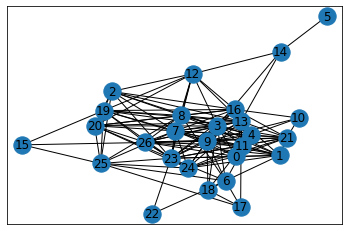

In [ ]:
# build the similarity graph
similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix) 
# view the similarity graph
networkx.draw_networkx(similarity_graph)

In [ ]:
# compute pagerank scores for all the sentences 
scores = networkx.pagerank(similarity_graph) 
# rank sentences based on their scores 
ranked_sentences = sorted(((score, index) for index, score in scores.items()), reverse=True) 
# view the ranked sentences 
ranked_sentences

[(0.04846907437866738, 0),
 (0.04773432706581962, 11),
 (0.0472137407242162, 3),
 (0.04695327795639603, 9),
 (0.04312146833319229, 4),
 (0.04206576873439963, 21),
 (0.04193495171501716, 23),
 (0.0409018727494599, 16),
 (0.039757842908499215, 7),
 (0.03832278193622313, 13),
 (0.03807478682576005, 10),
 (0.03652435340290444, 14),
 (0.03613054469728056, 8),
 (0.03534657397016055, 6),
 (0.03459499551267647, 24),
 (0.03390341177741563, 1),
 (0.03339292130079897, 25),
 (0.03332841786046865, 19),
 (0.033166944103422975, 26),
 (0.032458160796445604, 5),
 (0.032151933212533484, 12),
 (0.03178980569604903, 18),
 (0.031196491530645205, 20),
 (0.031100222095787194, 2),
 (0.03106180032204668, 17),
 (0.02973762300864629, 15),
 (0.02956590738506778, 22)]

In [ ]:
# get the top sentence indices for our summary 
top_sentence_indices = [ranked_sentences[index][1] for index in range(num_sentences)] 
top_sentence_indices.sort() 
# view the top sentence indices 
print(top_sentence_indices)

[0, 3, 4, 9, 11, 21, 23]


In [ ]:
# construct the document summary
for index in top_sentence_indices:
    print(story[index])

THE CLOUD
The little Cloud could see the poor people of the earth working and suffering in the hot fields , while she herself floated on the morning breeze , hither and thither , without a care .
" Oh , if I could only help the poor people down there !"
Sometimes they stood and looked up at the Cloud , as if they were praying , and saying , " Ah , if you could help us !"
said the Cloud .
" Yes , I will help you ," cried the Cloud once more .
As she said the words a wonderful light glowed from her heart , the sound of thunder rolled through the sky , and a love greater than words can tell filled the Cloud ; down , down , close to the earth she swept , and gave up her life in a blessed , healing shower of rain .


#### T5

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead

In [ ]:
# initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('t5-base')
model = AutoModelWithLMHead.from_pretrained('t5-base', return_dict=True, from_tf=True)

All TF 2.0 model weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


In [ ]:
sequence = str(story)

In [ ]:
inputs = tokenizer.encode("summarize: " + sequence,
                          return_tensors='pt',
                          max_length=512,
                          truncation=True)

In [ ]:
summary_ids = model.generate(inputs, max_length=170, min_length=120, length_penalty=5., num_beams=2)
# max_length defines the maximum number of tokens we’d like in our summary
# min_length defines the minimum number of tokens we’d like
# length_penalty allows us to penalize the model more or less for producing a summary below/above the min/max thresholds we defined
# num_beams sets the number of beams that explore the potential tokens for the most promising predictions [1]

In [ ]:
summary = tokenizer.decode(summary_ids[0])

In [ ]:
summary

'<pad> \'if I could only help the poor people down there!\', she thought.\'sometimes they stood and looked up at the Cloud. as they were praying. and saying, " Ah, if you could help us!\',\'said the Cloud. when she remembered this she held herself from sinking. and swayed here and there on the breeze, thinking,-- thinking. but at last she stood quite still. and spoke bold...</s>'

In [35]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                   max_df=0.95, min_df=2,
                                   max_features=5000,
                                   stop_words='english',
                                   #token_pattern='[a-zA-Z0-9]{3,}',
                                   #tokenizer=lambda doc: doc,
                                   #preprocessor=lambda doc: doc
                                  )
tfidf = tfidf_vectorizer.fit_transform(norm_corpus)

In [36]:
tfidf.shape

(50, 55)

In [37]:
nmf = NMF(n_components=2, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, 
          alpha=.1, l1_ratio=.5).fit(tfidf)

In [38]:
tfidf_features = tfidf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(nmf.components_):
    print ('\nTopic {}:'.format(topic_idx))
    top_features_ind = topic.argsort()[-10:]
    top_features = [tfidf_features[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    for topic, weight in zip(top_features, weights):
        print('{} - {:.5}'.format(topic, weight))


Topic 0:
stand - 0.19968
make - 0.20727
goose - 0.25063
say duck - 0.25063
say goose - 0.25063
duck - 0.25063
earth - 0.34552
help - 0.38605
cloud - 0.46366
say - 0.69477

Topic 1:
grain - 0.18318
grain wheat - 0.18318
plant - 0.27656
say little - 0.38718
hen - 0.53119
little red - 0.53119
red - 0.53119
red hen - 0.53119
little - 0.53955
wheat - 0.62748


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)